## Reinforcement Learning

### install required pacakges for RF in colab

In [ ]:
pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 5.3 MB/s 


### RF_ import modules and basic configurations

In [ ]:
# gym library for reinforcement learning
import gym

# math and random library for math modules and random numbers 
import math
import random

# numpy library 
import numpy as np

# matplotlib for visualization 
import matplotlib
import matplotlib.pyplot as plt

# collections library for data structures 
from collections import namedtuple, deque

from itertools import count

# torch library 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# specified certain version of gym library
# and exceptions 

if gym.__version__[:4] == '0.26':
    env = gym.make('CartPole-v1')
elif gym.__version__[:4] == '0.25':
    env = gym.make('CartPole-v1', new_step_api=True)
else:
    raise ImportError(f"Requires gym v25 or v26, actual version: {gym.__version__}")

# If one's environment is jupyter or collab , the code and the return is as follows  
# " is_ipython = True "
#

# set up matplotlib inline function 
# you can display images inside jupyter / colab , below code
is_ipython = 'inline' in matplotlib.get_backend()

# When you enable the ‘inline’ matplotlib backend, 
# the output of the plotting commands written will be displayed inline within the frontends like jupyter notebook. 
# It means, the plot/graph will be displayed directly below the cell (where the plotting commands are written) 
# and the resulted plot/graph will also be included (stored) in your notebook document.

if is_ipython:
    from IPython import display

# an example on how to use IPython display  
# from IPython.display import Image
# Image(filename='test.png') 

#the function to turn on interactive mode ( I.nteractivemode O.N.  = ion )
plt.ion()

# if gpu is to be used
# set device to cuda , and accelerate if cuda is available 
# else, set train device to cpu 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# How to make nametuple identity 

from collections import namedtuple

# namedtuple_structure_name as variable = namedtuple(tuplename,[tuple1,tuple2,tuple3,tuple4]) 
Employee = namedtuple('Employee',['first_name', 'last_name', 'country', 'jobs'])

# identity_name = namedtuple_structure_name(tuple1,tuple2,tuple3,tuple4)
andrew = Employee('Andrew', 'Brown', 'US', ['Developer', 'Manager'])

print(andrew)

Employee(first_name='Andrew', last_name='Brown', country='US', jobs=['Developer', 'Manager'])


In [ ]:
# namedtuple example 

hoji = Employee('Hoji','Kim',"KR",['Developer'])
print(hoji)

Employee(first_name='Hoji', last_name='Kim', country='KR', jobs=['Developer'])


In [ ]:
# how to use namedtuple? 
# feable examples

print(f'first_name by index[0]\t: {hoji[0]}') 
print(f'last_name by index[1]\t: {hoji[1]}') 
print(f'country by index[2]\t: {hoji[2]} \n') 

print(f'first_name by attribute\t:{hoji.first_name}') 
print(f'last_name by attribute\t:{hoji.last_name}') 
print(f'jobs by attribute\t:{hoji.jobs}') 

#Employee(*args)

first_name by index[0]	: Hoji
last_name by index[1]	: Kim
country by index[2]	: KR 

first_name by attribute	:Hoji
last_name by attribute	:Kim
jobs by attribute	:['Developer']


In [ ]:
# Transition - a named tuple representing a single transition in our environment. 
# It essentially maps (state, action) pairs to their (next_state, reward) result, 
# with the state being the screen difference image as described later on.

# In Python, most people don’t know — or usually forget about — 
# is that the language comes with an extension type called Named Tuple that is built on top of the core tuple type.

# So, what is namedtuple?
# can use indexes and attribute for lookup ( dic + list ?? )
# “factory function for creating tuple subclasses with named fields“ — Python docs

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


# what is replaymemory 
# ReplayMemory - a cyclic buffer of bounded size that holds the transitions observed recently. 
# 일정한 크기의 제한된 순환식 버퍼를 가지고 트랜지션 정보를 최신순으로 계속 받고 내보내는 일종의 데크 구조?라고 보면 되나 

# It also implements a .sample() method for selecting a random batch of transitions for training.
# 가지고 있는 버퍼에서 랜덤 배치로 자료를 선택하여 트레이닝도 가능하다. 

# 리플레이 메모리는 object를 부모클래스로 상속받은 자식클래스 
# 리플레이메모리(오브젝트)
# 자식클래스(부모클래스)

# what is object class in python
# 파이썬 3 코드에서 굳이 object를 상속시켜 주는 이유는 대개 파이썬 2와의 호환성 혹은 작성 취향 때문이다.
# 레퍼런스 : https://jh-bk.tistory.com/24
# 파이썬 3에선 old-style class를 만들 수 있는 방법은 공식적으론 없으며, 모든 클래스는 object를 상속받는 new-style class라고 보면 된다.

# 따라서 class ReplayMemory(object) == class ReplayMemory() ?? seems like it 

class ReplayMemory(object):
    
    # initialization function 
    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)
    
    # memory.push(state, action, next_state, reward)
    # usage is like this ---> push(Transition("*args -> state,action,next_state,reward")) 
    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    # what is def__len__()???? 

    # when we call len(s) method, s.__len__() is what actually happening behind the scenes to calculate the length.
    # def len(s):
    # return s.__len__()

    def __len__(self):
        return len(self.memory)

In [ ]:
# inherits torch nn.Module 
# Deep Q Network 


class DQN(nn.Module):
    # DQN은 initialized 될 때 DQN(n_obs,n_actions) 으로 동작한다 

    def __init__(self, n_observations, n_actions):
        
        # super().__init__() → python 3 에서만 작동
        # super(클래스,self).__init__() → python 2,3 모두 작동
        # DQN 에서 nn.Module 의 함수들을 사용하겠다

        super(DQN, self).__init__()

        # DQN의 layer1,2,3  
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    
    # 일반적인 연결구조 
    # One element를 return 하면 다음에 취할 액션이 리턴될 것 
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [ ]:
# Deterministic Environment 

# Q - Learning Idea
# The main idea behind Q-learning is that 
# if we had a function Q*: State X Action -> R 
# that could tell us what our return would be, 

# 함수 Q(상태,행동)가 있다면 어떤 상태에서 특정 행동을 취함으로써 얻는 보상을 알 수 있다.
# 주어진 상황에서 행동을 취한다고 가정하면 보상을 극대화 하는 폴리시를 쉽게 구성할 수 있다.

# DQN - Learning Idea 
# given Q(s,a) -> R를 모르니, 뉴럴 네트워크로 근사(Resemble)한다 


# BATCH_SIZE is the number of transitions sampled from the replay buffer
# works like this 
# memory = ReplayMemory(10000)
# transitions = memory.sample(BATCH_SIZE)

# 리플레이 메모리 클래스를 할당받은 메모리에서 128만큼 배치 사이즈를 랜덤으로 샘플링하겠다 
BATCH_SIZE = 128

# GAMMA is the discount factor as mentioned in the previous section
# constant between 0 ~ 1 -> sum must be converged
GAMMA = 0.99

# policy(S) = argmax(current State, action)
# 현 상태에서 어떤 액션을 취했을때 가장 높은 Q-value를 리턴하는 폴리시

# every Q function for some policy obeys the Bellman equation:
# Q(policy(state,action)) = { return + gamma(Q(policy(next state, policy(next state))) }
# temporal difference error = Q(policy(state,action)) - { return + gamma(Q(policy(next state, policy(next state))) }
# uses Huber loss 


# Epsilon parameter
# Uses Epsilon greedy policy 
# controls the rate of the decay (higher = slower decay )
EPS_DECAY = 1000

# Epsilon start value , 0.9 
EPS_START = 0.9
# Epsilon end value , 0.05 
# 0.9 -> exp_decay towards -> 0.05 
EPS_END = 0.05

# TAU is the update rate of the target network
TAU = 0.005

# LR is the learning rate of the AdamW optimizer
LR = 1e-4

# Get number of actions from gym action space
# print("n_actions", n_actions) -> 2 
# Q(s,left) or Q(s,right)
n_actions = env.action_space.n
# print("n_actions", n_actions)

# Get the number of state observations
if gym.__version__[:4] == '0.26':
    state, _ = env.reset()
elif gym.__version__[:4] == '0.25':
    state, _ = env.reset(return_info=True)

# n_observations = 4 
# DQN에서는 기본적으로 4개의 연속된 observation들이 들어감으로서 
# 상황의 흐름을 train 할 수 있다 
n_observations = len(state)
# print("n_observations :",len(state))

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

# nn.Module.load_state_dict() 
# print("state_dict" ,policy_net.state_dict())
# loads weight * bias for each layer 
# 폴리시 넷 ( 타우에 따라 늦게 업데이트 된 )의 가중치와 편향을 타겟 넷에 적재하는 과정 
target_net.load_state_dict(policy_net.state_dict())

# amsgrad = auto 
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    # steps_done 을 전역 변수로 설정 
    global steps_done
    
    # 난수생성
    sample = random.random()
    
    # epsilon을 매 스텝이 진행됨에 따라 지수적으로 증가해주는 구간 
    # exp(0) = 1
    # 0에 가까워질 수록 1에 수렴하는 지수함수 

    # 0.05 + ( 0.85 ) * exp(-1 * 1/1000 ) -> 거의 0.05 + 0.85 
    # 0.05 + ( 0.85 ) * exp(-1 * 1/2 ) -> 거의 0.05 + 0.085 * (0.7)
    # 0.05 + ( 0.85 ) * exp(-1 * 1/1 ) -> 거의 0.05 + 0.85 * (0.6)
    # 즉 STEPS DONE이 진행될수록 EPSILON이 DECAY 되게끔 작성된 코드다 
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    
    steps_done += 1
    
    # 만약 생성한 난수가 허용치보다 높은 경우에는 
    # Q.argmax(state)로 액션을 정한다 

    # torch.no_grad()의 주된 목적은 autograd를 끔으로써 메모리 사용량을 줄이고 연산 속도를 높히기 위함
    # 이 컨텍스트 내부에서 새로 생성된 텐서들은 requires_grad=False 상태가 되어, 메모리 사용량을 아껴준다.
    
    # 만약 생성한 난수가 허용치보다 낮은 경우에는 
    # 무작위로 액션을 설정한다 
    
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


# plot_durations for plotting 
def plot_durations(show_result=False):
    
    plt.figure(1)

    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [ ]:
torch.cuda.is_available()

False

Complete


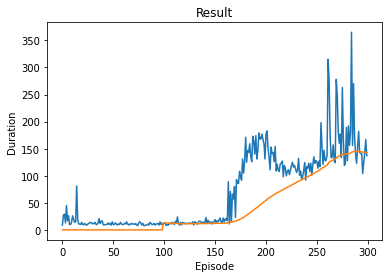

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
# set num_epsides ~ GPU availability
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

# episode tranining 
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    
    # gym.__version__ 0.26 returns info without any args
    if gym.__version__[:4] == '0.26':
        state, _ = env.reset()
    # gym.__version__ 0.25 args must be set True to return_info
    elif gym.__version__[:4] == '0.25':
        state, _ = env.reset(return_info=True)
    # env.reset resets the state of the env and returns an initial obs.
    # 매 에피소드가 끝나면 env state를 초기화 해줌 
    
    # 매번 초기화 되는 state 
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    # print(state)
    # tensor([[0.0092, 0.0344, 0.0363, 0.0075]])
     
    # counts() counts each loop 
    # t -> 1 -> 2 -> 3.... end 

    for t in count():    
        # takes action ( from current state )
        action = select_action(state)
        
        # In the old opengym API 
        # done was returned as True if episode ends in any way.
        # In the new API, done is split into 2 parts: terminated -> truncated 

        observation, reward, terminated, truncated, _ = env.step(action.item())
        
        # moves reward to device( cuda or cpu )
        reward = torch.tensor([reward], device=device)
        
        # one loop finished anyway 
        done = terminated or truncated
        
        # If terminated is returned as True , there is no next_state ... so, 
        if terminated:
            next_state = None
        # If terminated is returned as False, next_state exists ... so, 
        # next_state가 다음과 같이 선언된다. 
        # next_state의 인풋 역시 , DQN 처음 인풋대로 4개의 STATE가 들어간다 
        else:
            # print(observation,"observation")
            # [-0.04615159  0.23102479 -0.03562462 -0.30272973] observation
            
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        # push(args) into namedtuple Transition 
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        
        # 같은 키에 해당되는 텐서들을 계산해줌 
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        
        # 계산한 텐서들을 타겟 넷에 적재해줌 
        target_net.load_state_dict(target_net_state_dict)
        
        # if terminated or truncated is true 
        # epsiode 한개는 끝났다고 생각해서 그만큼 진행을 해줌 ( 플롯을 위해서 )
        if done:
            episode_durations.append(t + 1)

            # plot_durations() -> show_result -> False ( default )
            plot_durations()
            break

print('Complete')

# plot_durations() -> show_result false --> True ( shows result )
plot_durations(show_result=True)
plt.ioff()
plt.show()